 <h1><center><font color='red'> PROJET SCIENCE DES DONNEES</font></center></h1>
 <h1><center><font>  Le débat présidentiel: Un combat de mots</font></center></h1>

 <h6><font ><center>“Public sentiment is everything.” — Abraham Lincoln</font></center></h6>


<h2><font color='green'> Sommaire</font></h2>
<ol>

<h4><li>Business Understanding</li>

<li>Data Understanding </li>

<li>Data Preperation </li>
    
<li>Modeling and Evaluation</li>

<li>Deployment </li></h4>

</ol>

<ol><h3><li>Business Understanding </li></h3></ol>
In order to better understand the presidential debates , we looked at it with  Data Science ,
we'll run through the steps of our project and leave of the main findings we came up with that allows us to answer some key questions like:
What is the sentiment for a given speech? Is it positive or negative?
What are the most frequently used words in positive/negative speechs?

In [2]:
!pip install wordcloud

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [6]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.probability import FreqDist
import collections
from collections import Counter
import seaborn as sns
from nltk.util import ngrams
from nltk import bigrams
import gensim
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow
from tensorflow import keras

<h4><li>Load data and take a quick look into the data </li></h4>


In [8]:
#Load data and take a quick look into the data
data = pd.read_csv('/content/drive/MyDrive/debate_transcripts_USA.csv', encoding='cp1252')

<h3>2. Data Understanding </h3>

In [9]:
# Dataset Visualisation 
data

,debate_name,debate_section,speaker,speech,speaking_time_seconds
0,New Hampshire Democratic Debate Transcript,Part 1,George S.,"Candidates, welcome. Vice President Biden, the...",18.0
1,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Oh, they didn’t miss anything. It’s a long rac...",36.0
2,New Hampshire Democratic Debate Transcript,Part 1,George S.,Why are Senator Sanders and Mayor Buttigieg to...,4.0
3,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Well, you know that with regard to Senator San...",41.0
4,New Hampshire Democratic Debate Transcript,Part 1,George S.,"Senator Sanders, let me give you the chance to...",21.0
...,...,...,...,...,...
5328,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Bernie Sanders,"Unfortunately Rulac, among other groups, Latin...",17.0
5329,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Bernie Sanders,"But where we don’t agree, I think, is why we a...",24.0
5330,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Bernie Sanders,"Bottom line here, real change never takes plac...",19.0
5331,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Lester Holt,"Senator thank you. Folks, thank you. That conc...",21.0


In [10]:
# Dataset dimension 
data.shape

(5333, 5)

In [11]:
# Variables
data.columns

Index(['debate_name', 'debate_section', 'speaker', 'speech',
       'speaking_time_seconds'],
      dtype='object')

Our data contains 5333 rows and 5 columns.

Each row was tagged with the following: 'debate_name', 'debate_section', 'speaker', 'speech','speaking_time_seconds'

In [12]:
# Missing values
data.isnull().sum()

debate_name                0
debate_section             0
speaker                    0
speech                     0
speaking_time_seconds    513
dtype: int64

The column speaking_time_seconds contains 513 missing values.

<h3>3. Data Preperation </h3>


<h4>a-Data PreProcessing </h4>

<h4><li>Supprimer toutes les lignes qui ne contiennent pas de temps de parole. </li></h4>

In [13]:
# Dropping missing values
NewData = data.dropna()

In [14]:
# Verification
NewData.isnull().sum()

debate_name              0
debate_section           0
speaker                  0
speech                   0
speaking_time_seconds    0
dtype: int64

<h4><li>Supprimer toutes les lignes qui concernent d’autres intervenants à part les candidats (cad qu’il faut supprimer les     interventions des journalistes, etc.) </li></h4>

In [15]:
Liste=["Elizabeth Warren", "Amy Klobuchar", "Beto O’Rourke", "Cory Booker", "Julian Castro", "Tulsi Gabbard", "Bill de Blasio", "John Delaney", "Governor Inslee", "Congressman Ryan", "Bernie Sanders", "Michael Bennet", "Joe Biden","Kamala Harris", "John Hickenlooper", "Kirsten Gillibrand", "Pete Buttigieg", "Andrew Yang", "Congressman Swalwell", "Marianne Williamson", "Steve Bullock", "Tom Steyer", "Michael Bloomberg"]
# Create a new database 'NewData1' that contains only the candidates
NewData1 = NewData[NewData['speaker'].isin(Liste)]

In [16]:
NewData1

,debate_name,debate_section,speaker,speech,speaking_time_seconds
1,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Oh, they didn’t miss anything. It’s a long rac...",36.0
3,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Well, you know that with regard to Senator San...",41.0
5,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,Because Donald Trump lies all the time. It doe...,41.0
6,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,I believe that the way we beat Trump is by hav...,39.0
8,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,That’s true. And that’s the disappointment and...,23.0
...,...,...,...,...,...
5324,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Joe Biden,… there would be 10 … Six million members woul...,2.0
5326,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Joe Biden,… now American citizens.,2.0
5328,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Bernie Sanders,"Unfortunately Rulac, among other groups, Latin...",17.0
5329,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Bernie Sanders,"But where we don’t agree, I think, is why we a...",24.0


==> As we can see , the newdata that contains only the candidates  has 2787 rows and 5 columns.

<h4><li>Supprimer toutes les lignes des intervenants qui ont eu un temps de parole cumulé inférieur à 1200s</li></h4>

In [17]:
NewData2 = NewData1.groupby(['speaker']).sum()

In [18]:
df2 = NewData2[NewData2["speaking_time_seconds"] >= 1200]

In [19]:
#Sort the cumulative speaking time 
df2['speaking_time_seconds'] = df2['speaking_time_seconds'].sort_values()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
#Delete all the lines of the speakers who had a cumulative speaking time lower than 1200s
Liste= df2.index
final = NewData1[NewData1['speaker'].isin(Liste)]

Here , we created our final dataset , the one  we are going considerate in the upcoming steps  , which contains only the candidates with speaking_time _seconds >=1200.

In [21]:
final

,debate_name,debate_section,speaker,speech,speaking_time_seconds
1,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Oh, they didn’t miss anything. It’s a long rac...",36.0
3,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Well, you know that with regard to Senator San...",41.0
5,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,Because Donald Trump lies all the time. It doe...,41.0
6,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,I believe that the way we beat Trump is by hav...,39.0
8,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,That’s true. And that’s the disappointment and...,23.0
...,...,...,...,...,...
5324,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Joe Biden,… there would be 10 … Six million members woul...,2.0
5326,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Joe Biden,… now American citizens.,2.0
5328,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Bernie Sanders,"Unfortunately Rulac, among other groups, Latin...",17.0
5329,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Bernie Sanders,"But where we don’t agree, I think, is why we a...",24.0


<h4>En enrichissant les stop words standards de la langue anglaise avec des mots de votre choix, étant donné le contexte du corpus (par exemple en analysant les 20 mots les plus utilisés dans le corpus), rajouter une nouvelle colonne « clean_speech » qui supprime les stop words de la 5ème colonne « speech »</h4>



In [22]:
# Insert new column named "clean_speech" that contains the value "Any" in 5th position
final.insert(5,"clean_speech", "Any")

In [23]:
#Remove Stop words
stop_words = set(nltk.corpus.stopwords.words('english'))
r = r'[^\w\d]'
for word in ["its", "’","," ,".","I","a","about","an","are","as","at","be","by","for","from","how","in","is","it","of","on","or","that","the","this","to","was","what","when","where","who","will","with","the","would", "us", "then", "so", "it", "thats", "going", "also"]:
    stop_words.add(word)
final["clean_speech"] = final["speech"].apply(lambda x: " ".join([re.sub(r,'', item.lower()) for item in x.split() if re.sub(r,'', item.lower()) not in stop_words]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
final

,debate_name,debate_section,speaker,speech,speaking_time_seconds,clean_speech
1,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Oh, they didn’t miss anything. It’s a long rac...",36.0,oh didnt miss anything long race took hit iowa...
3,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Well, you know that with regard to Senator San...",41.0,well know regard senator sanders president wan...
5,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,Because Donald Trump lies all the time. It doe...,41.0,donald trump lies time doesnt matter donald tr...
6,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,I believe that the way we beat Trump is by hav...,39.0,believe way beat trump largest voter turnout h...
8,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,That’s true. And that’s the disappointment and...,23.0,true disappointment think probably could done ...
...,...,...,...,...,...,...
5324,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Joe Biden,… there would be 10 … Six million members woul...,2.0,10 six million members
5326,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Joe Biden,… now American citizens.,2.0,american citizens
5328,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Bernie Sanders,"Unfortunately Rulac, among other groups, Latin...",17.0,unfortunately rulac among groups latino groups...
5329,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Bernie Sanders,"But where we don’t agree, I think, is why we a...",24.0,dont agree think today major country earth gua...


<h4>b- Data Processing </h4>


<h4> Tracer un graphique montrant le candidat qui a pris le plus de temps de parole cumulé</h4>

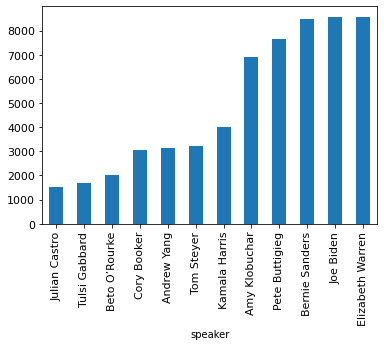

In [27]:
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax = df2.groupby(df2.index)["speaking_time_seconds"].sum().sort_values()
ax.plot.bar()

The figure shows that the candidate who took the most cumulative speaking time is Elizabeth Warren with 8571 seconds and the one who took the least cumulative speaking time is Julian Castro with 1534 seconds.

<h4> Afficher un nuage de mots avec les 20 mots les plus utilisés dans la nouvelle colonne « clean_speech »</h4>

In [28]:
#Tokenization of clean_speech column
clean_tok = final.apply(lambda row: nltk.word_tokenize(row['clean_speech']),axis=1)

In [29]:
#Creation of new column clean_tok
final.insert(6,'clean_tok','Any')
final['clean_tok']=clean_tok

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
#Calculation of the frequency of each word
l=[]
for i in final['clean_tok']:
    l=l+i
freq_dist = FreqDist(l)
freq_dist

FreqDist({'oh': 21,
          'didnt': 104,
          'miss': 6,
          'anything': 47,
          'long': 71,
          'race': 51,
          'took': 53,
          'hit': 15,
          'iowa': 37,
          'ill': 66,
          'probably': 19,
          'take': 227,
          'traditionally': 1,
          'bernie': 54,
          '20': 39,
          'points': 30,
          'last': 100,
          'time': 288,
          'usually': 2,
          'neighboring': 1,
          'senators': 26,
          'well': 316,
          'matter': 75,
          'im': 416,
          'still': 68,
          'reason': 70,
          'restore': 17,
          'soul': 15,
          'country': 594,
          'bring': 178,
          'back': 215,
          'middle': 82,
          'class': 73,
          'make': 450,
          'sure': 238,
          'people': 1182,
          'together': 175,
          'simple': 21,
          'proposition': 1,
          'doesnt': 77,
          'whether': 96,
          'one': 572,
    

Word clouds or tag clouds are graphical representations of word frequency that give greater prominence to words that appear more frequently in a source text. The larger the word in the visual the more common the word was in the document(s).

In [31]:
cloud_generator = WordCloud(random_state=1,height=1000, width = 1000,background_color='salmon',colormap = 'Pastel2',collocations=False)
wordcloud_image = cloud_generator.generate_from_frequencies(dict (freq_dist.most_common(20)))

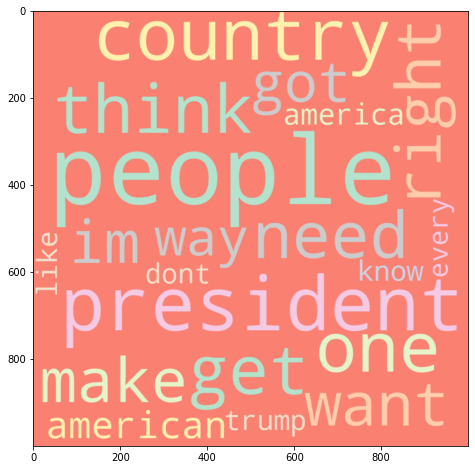

In [32]:
plt.figure(figsize=(8,8))
plt.imshow(wordcloud_image, interpolation="bilinear")
plt.show()

to find the most common words in each of the debates  We use the popular package known as NLTK to get the most common words (after preprocessing)

<h4> Afficher pour chaque candidat la liste des 10 mots les plus utilisés</h4> 

In [33]:
#A function that calculates and displays the 10 most frequent words for each condidate
def mot_freq (x):
    eap = final[final['speaker'] == x]
    l=[]
    for i in eap['clean_tok']:
        l=l+i

    eap_counts = Counter(l)
    eap_common_words = [word[0] for word in eap_counts.most_common(10)]
    eap_common_counts = [word[1] for word in eap_counts.most_common(10)]

    plt.style.use('dark_background')
    plt.figure(figsize=(15, 12))
    sns.barplot(x=eap_common_words, y=eap_common_counts)
    plt.title('Most 10 Common Words of '+x);

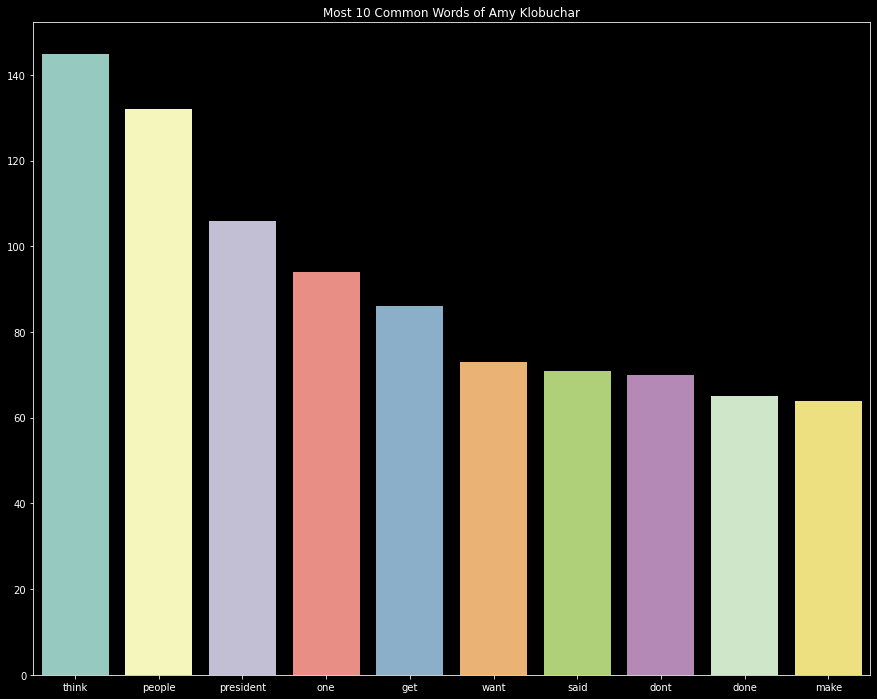

In [34]:
#Most 10 common words of Amy Klobuchar
mot_freq ('Amy Klobuchar')

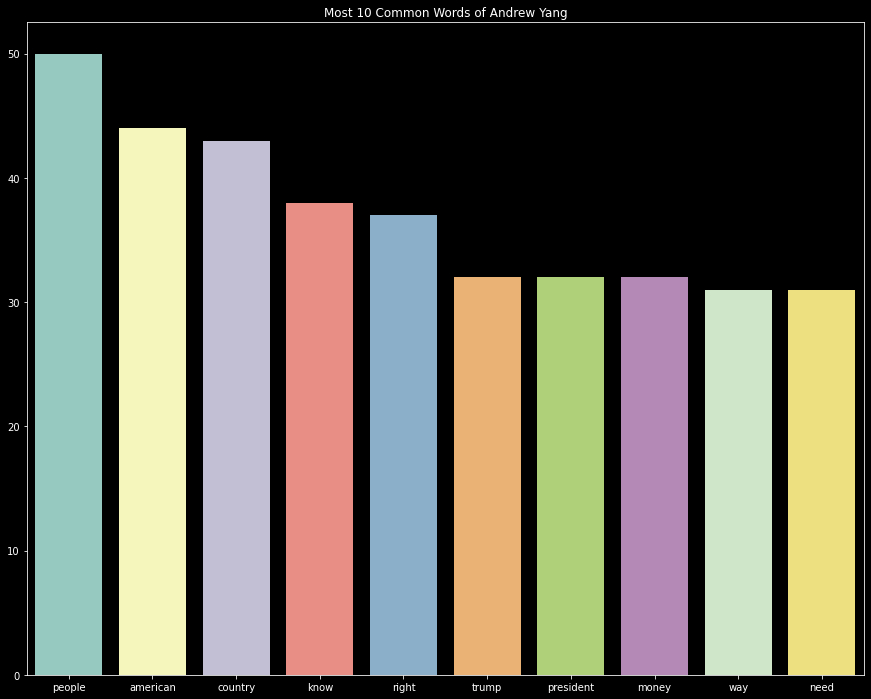

In [35]:
#Most 10 common words of Andrew Yang
mot_freq ('Andrew Yang')

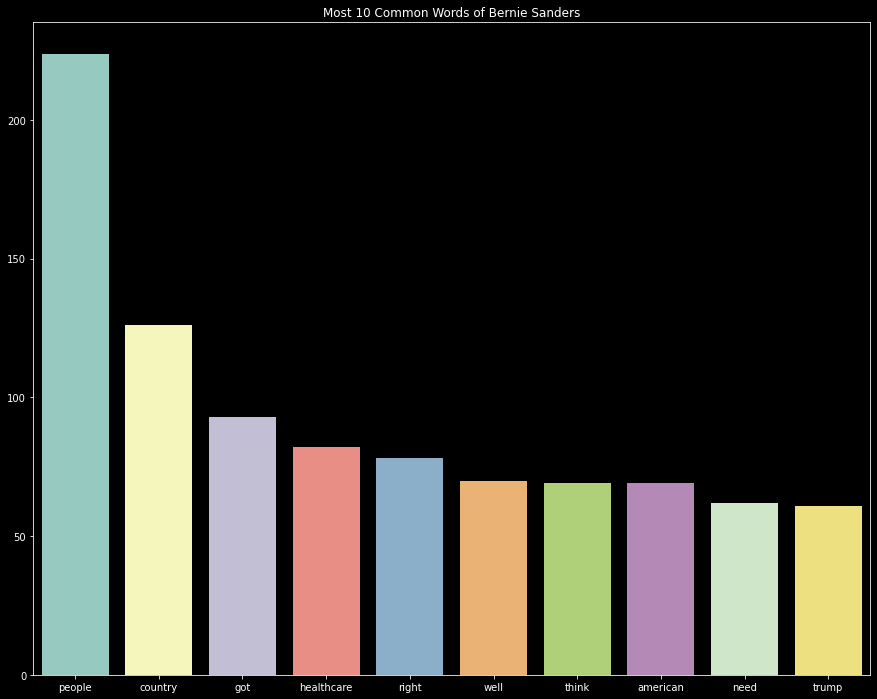

In [36]:
#Most 10 common words of Bernie Sanders
mot_freq ('Bernie Sanders')

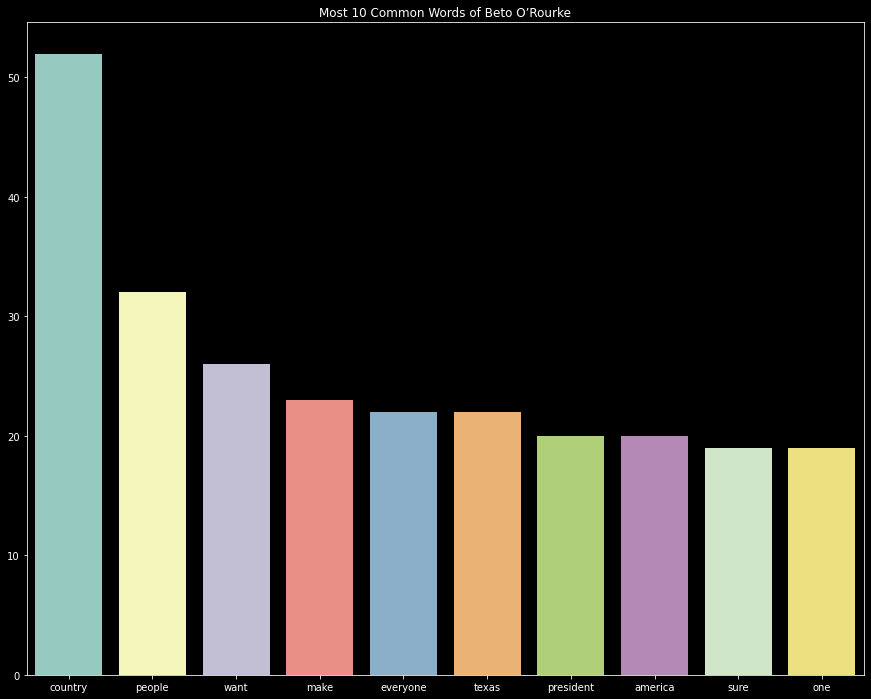

In [37]:
#Most 10 common words of Beto O’Rourke
mot_freq ('Beto O’Rourke')

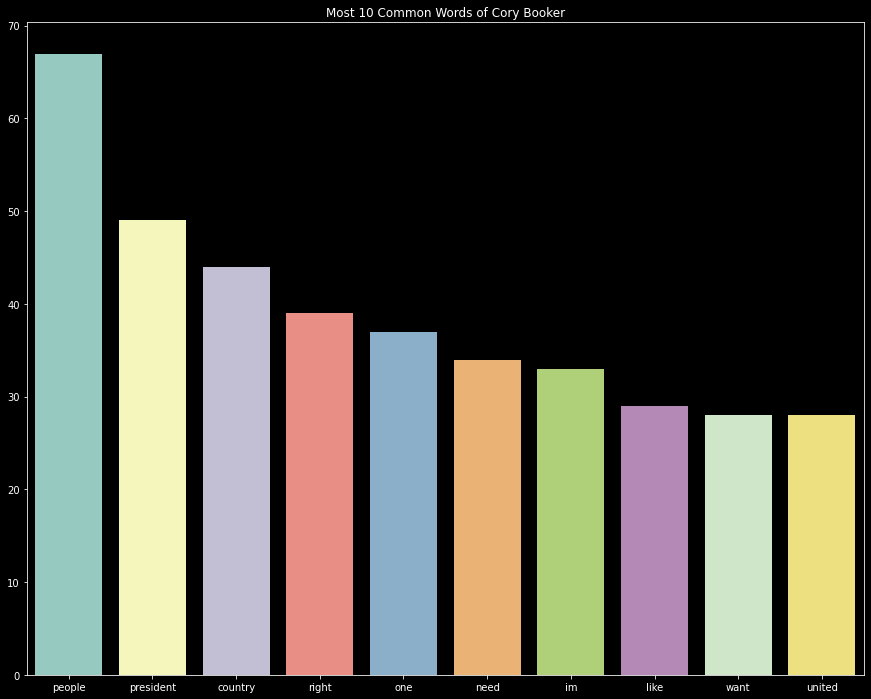

In [38]:
#Most 10 common words of Cory Booker
mot_freq ('Cory Booker')

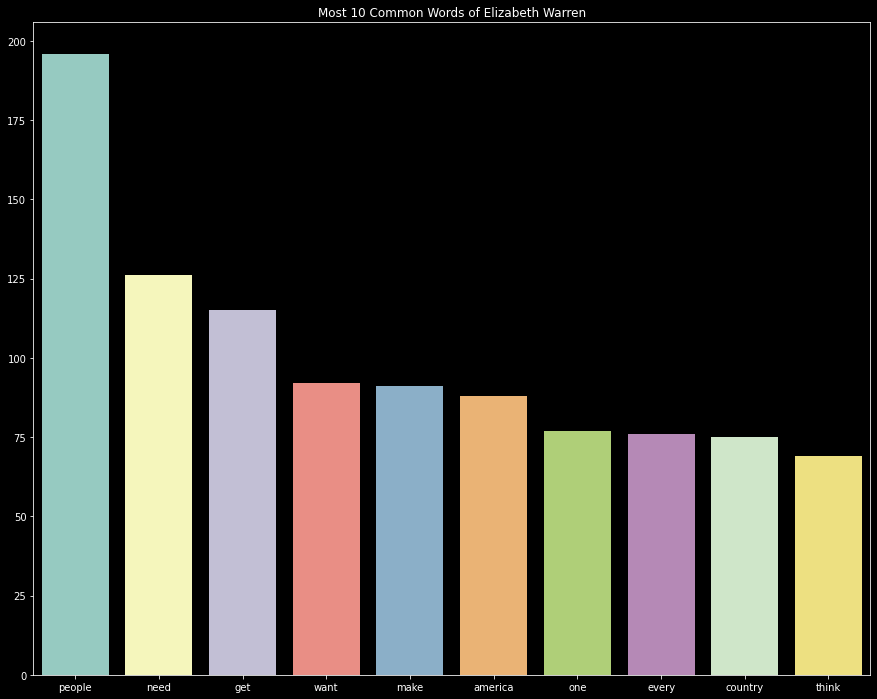

In [39]:
#Most 10 common words of Elizabeth Warren
mot_freq ('Elizabeth Warren')

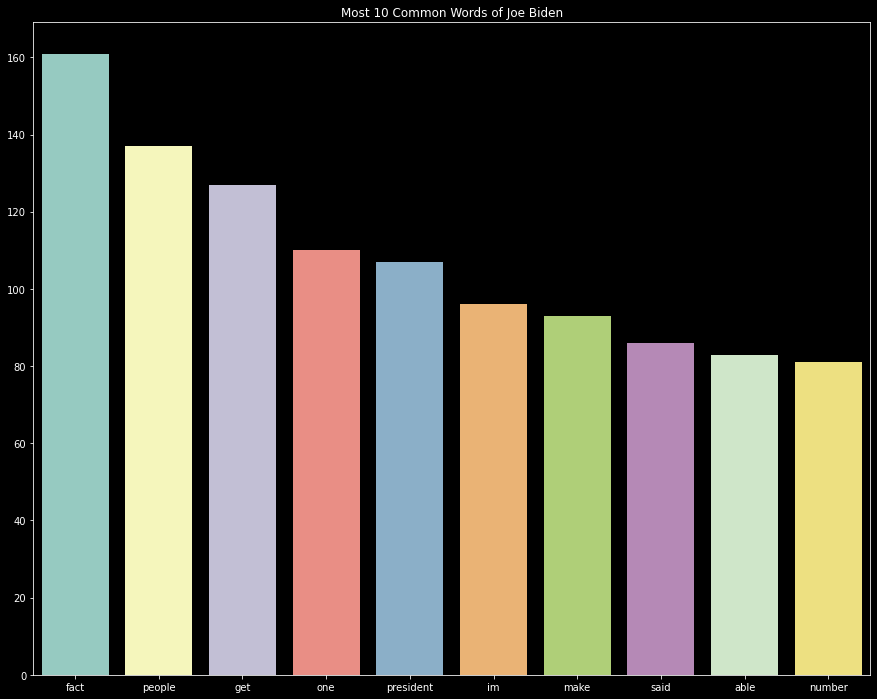

In [40]:
#Most 10 common words of Joe Biden
mot_freq ('Joe Biden')

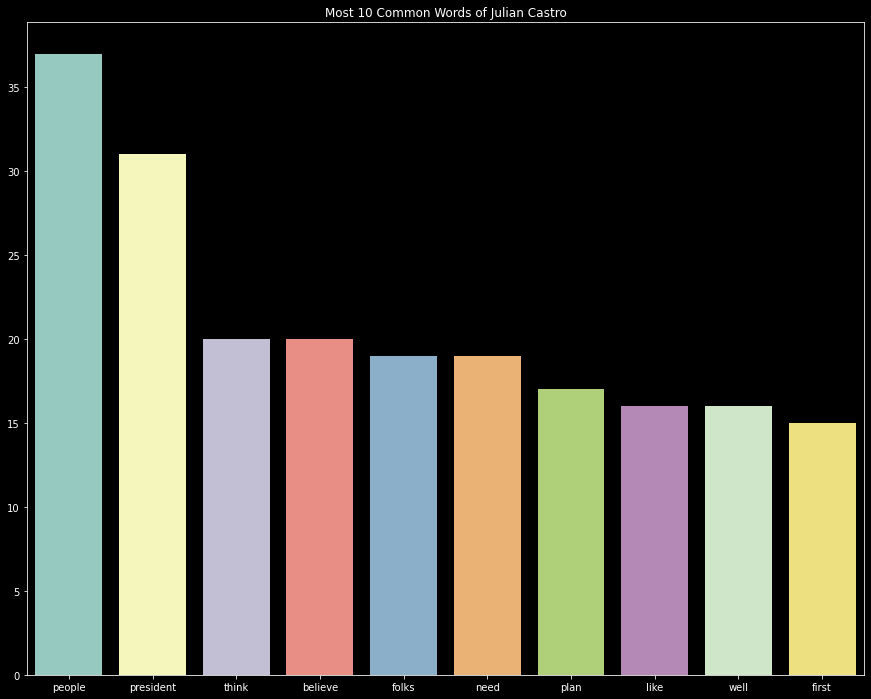

In [41]:
#Most 10 common words of Julian Castro
mot_freq ('Julian Castro')

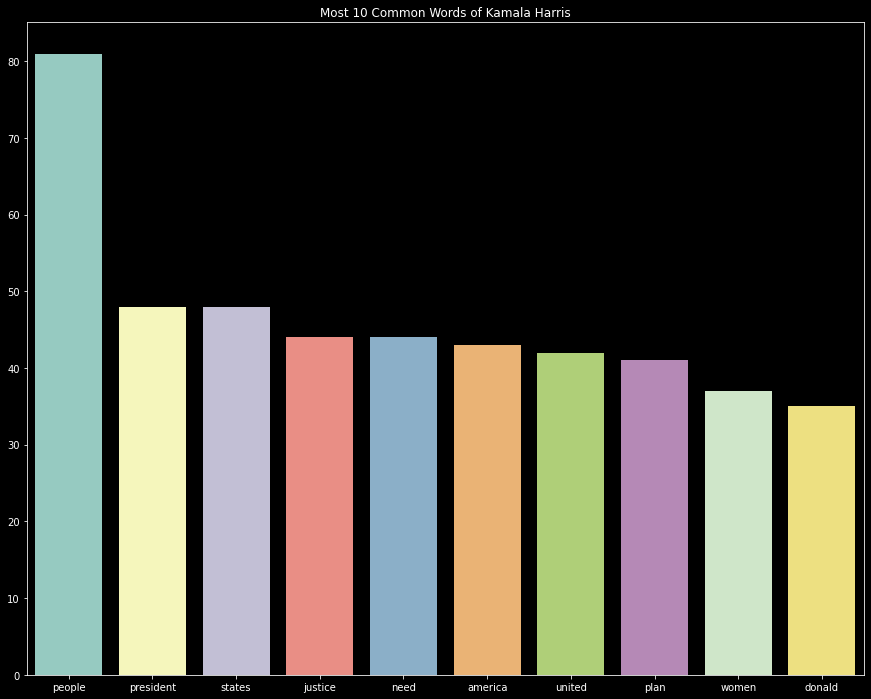

In [42]:
#Most 10 common words of Kamala Harris
mot_freq ('Kamala Harris')

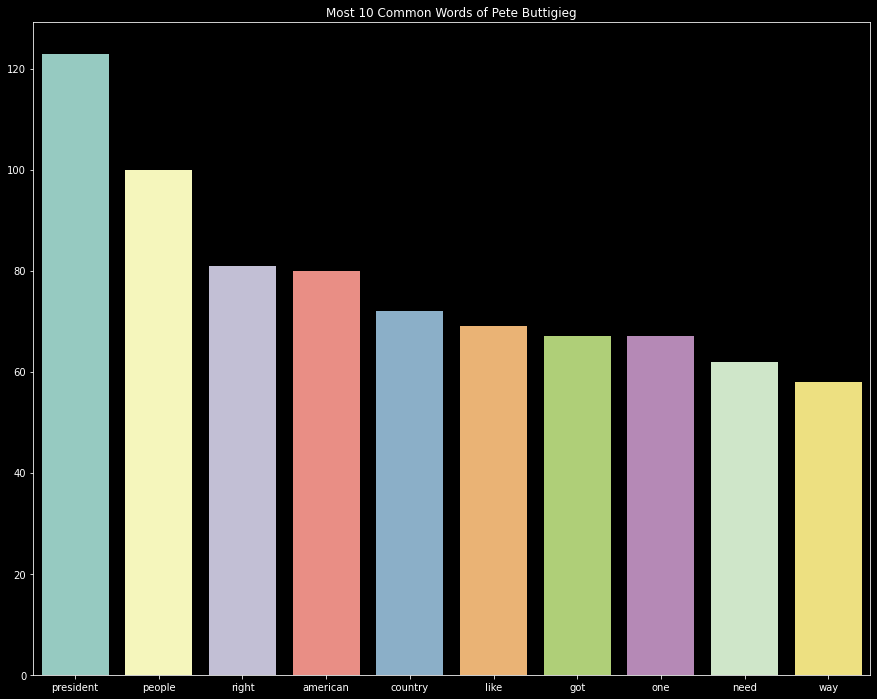

In [43]:
#Most 10 common words of Pete Buttigieg
mot_freq ('Pete Buttigieg')

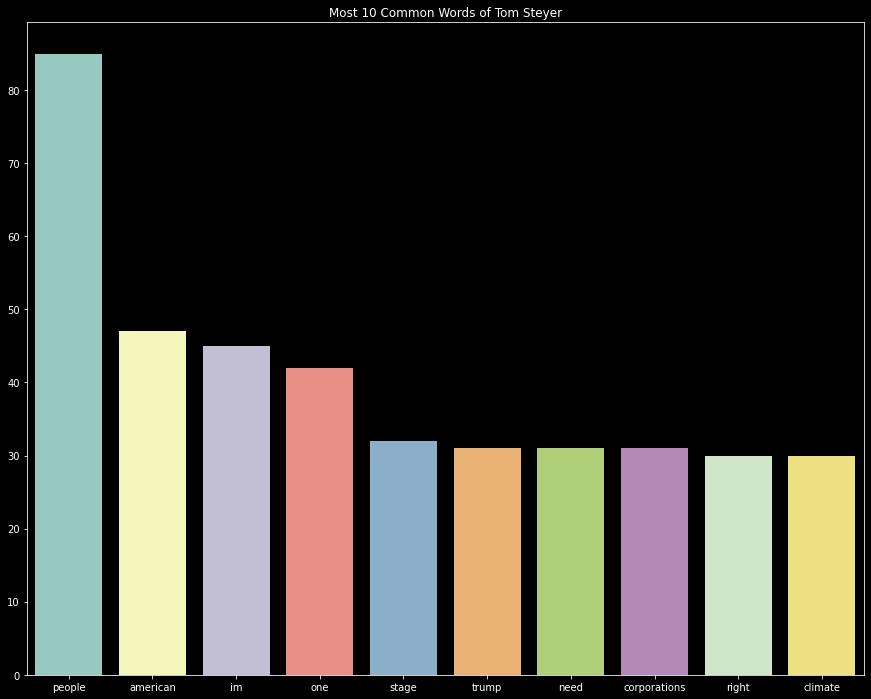

In [44]:
#Most 10 common words of Tom Steyer
mot_freq ('Tom Steyer')

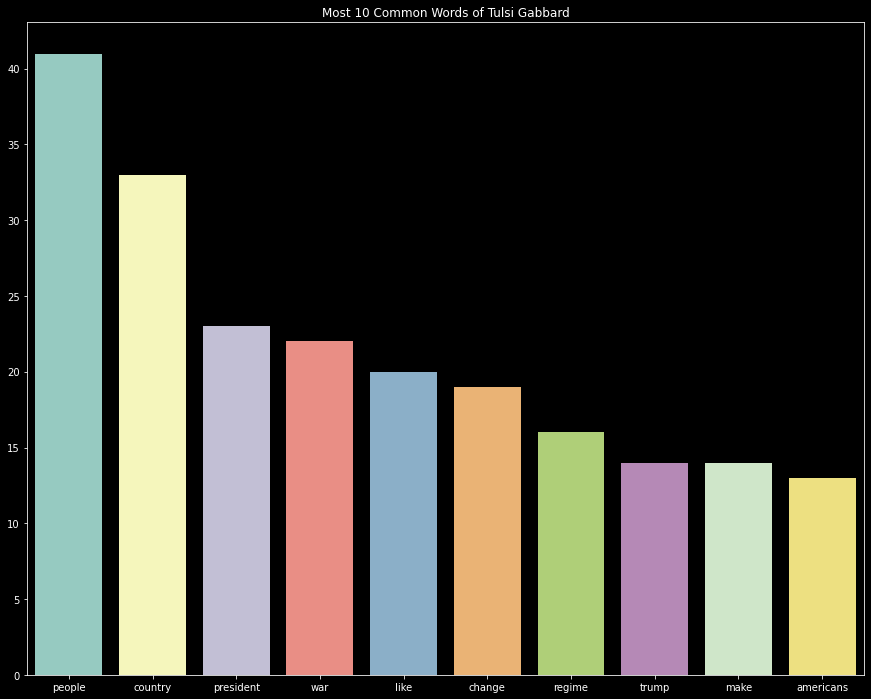

In [45]:
#Most 10 common words of Tulsi Gabbard
mot_freq ('Tulsi Gabbard')

<h4> Le sujet de la santé « healthcare » semble être un point commun entre les candidats démocrates, proposer un graphique qui permet une analyse plus fine de ce constat </h4>

In [46]:
#A function that calculates the frequency of the word Heathcare for each condidate
def freq(x):
    eap = final[final['speaker'] == x]
    l=[]
    for i in eap["clean_tok"]:
        l=l+i
    fdist = FreqDist(l)
    return(fdist['healthcare'])

In [47]:
for i in df2.index:
    print(i,"said the word 'Healthcare':",freq(i),"times")
l=[]
for i in df2.index:
    l.append(freq(i))

Amy Klobuchar said the word 'Healthcare': 10 times
Andrew Yang said the word 'Healthcare': 9 times
Bernie Sanders said the word 'Healthcare': 82 times
Beto O’Rourke said the word 'Healthcare': 11 times
Cory Booker said the word 'Healthcare': 6 times
Elizabeth Warren said the word 'Healthcare': 45 times
Joe Biden said the word 'Healthcare': 9 times
Julian Castro said the word 'Healthcare': 7 times
Kamala Harris said the word 'Healthcare': 27 times
Pete Buttigieg said the word 'Healthcare': 19 times
Tom Steyer said the word 'Healthcare': 8 times
Tulsi Gabbard said the word 'Healthcare': 3 times


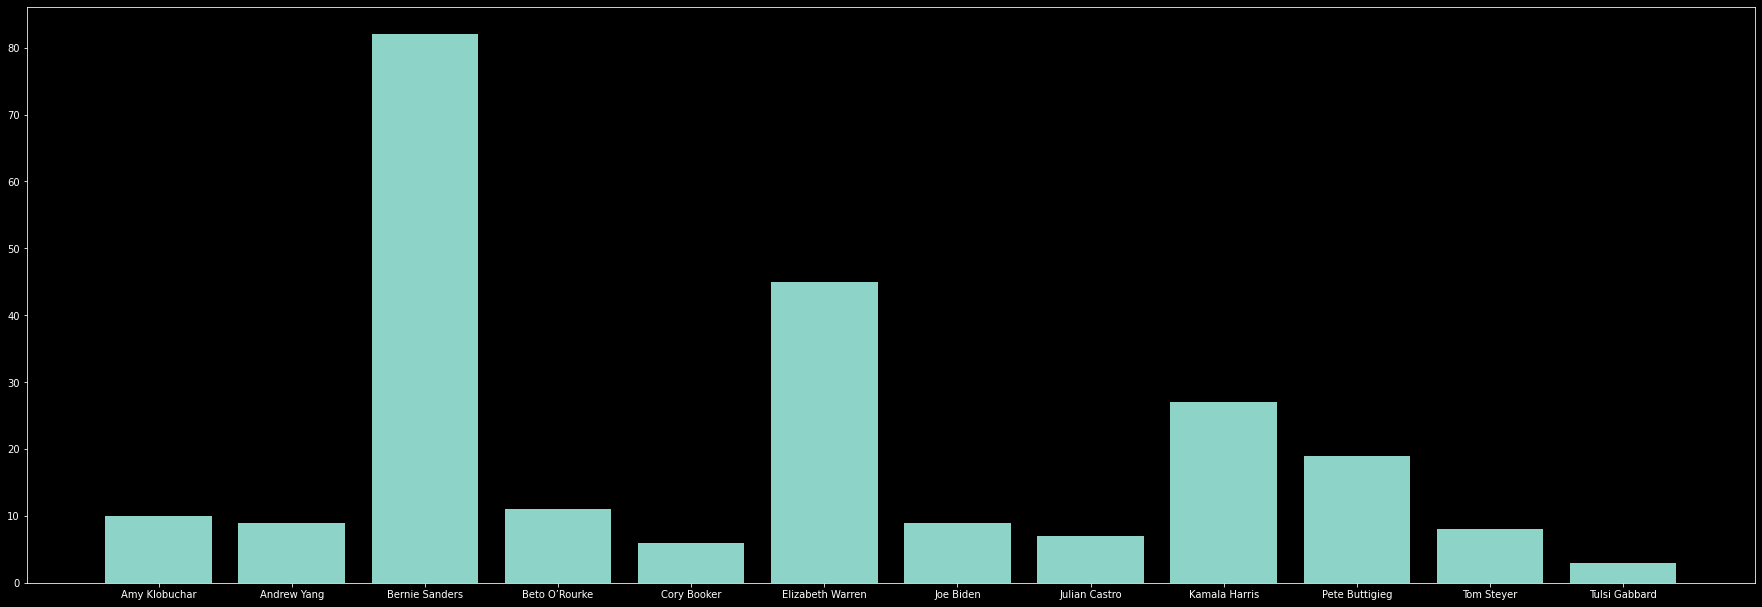

In [48]:
fig = plt.figure()
ax = fig.add_axes([0,0,4,2])
langs = df2.index
students = l
ax.bar(langs,students)
plt.show()

This graph shows the frequency of the word Heathcare for each condidate

<h4>Pour avoir une idée de la tendance globale, il est demandé de tracer des graphiques avec les 10 bigrammes et les 10 trigrammes les plus fréquents pour l’ensemble des candidats</h4>

<h5> 1. Bigram</h5>

In [49]:
#Concatenation of clean_tok lists into a single list 
l = []
for i in final['clean_tok']:
    l = l + i

In [50]:
#Calculate the frequency of each couple
bigrams = FreqDist(ngrams(l, 2))
bigrams

FreqDist({('oh', 'didnt'): 1,
          ('didnt', 'miss'): 1,
          ('miss', 'anything'): 1,
          ('anything', 'long'): 1,
          ('long', 'race'): 1,
          ('race', 'took'): 1,
          ('took', 'hit'): 1,
          ('hit', 'iowa'): 1,
          ('iowa', 'ill'): 1,
          ('ill', 'probably'): 1,
          ('probably', 'take'): 1,
          ('take', 'hit'): 1,
          ('hit', 'traditionally'): 1,
          ('traditionally', 'bernie'): 1,
          ('bernie', '20'): 1,
          ('20', 'points'): 5,
          ('points', 'last'): 1,
          ('last', 'time'): 11,
          ('time', 'usually'): 1,
          ('usually', 'neighboring'): 1,
          ('neighboring', 'senators'): 1,
          ('senators', 'well'): 1,
          ('well', 'matter'): 2,
          ('matter', 'im'): 1,
          ('im', 'still'): 4,
          ('still', 'reason'): 1,
          ('reason', 'restore'): 1,
          ('restore', 'soul'): 5,
          ('soul', 'country'): 5,
          ('country', 'br

In [51]:
#Select the 10 most frequent bigrams for all candidates
print(bigrams.most_common(10))

[(('donald', 'trump'), 245), (('united', 'states'), 244), (('american', 'people'), 152), (('make', 'sure'), 145), (('weve', 'got'), 97), (('can', 'not'), 97), (('every', 'single'), 86), (('climate', 'change'), 86), (('president', 'united'), 83), (('number', 'one'), 61)]


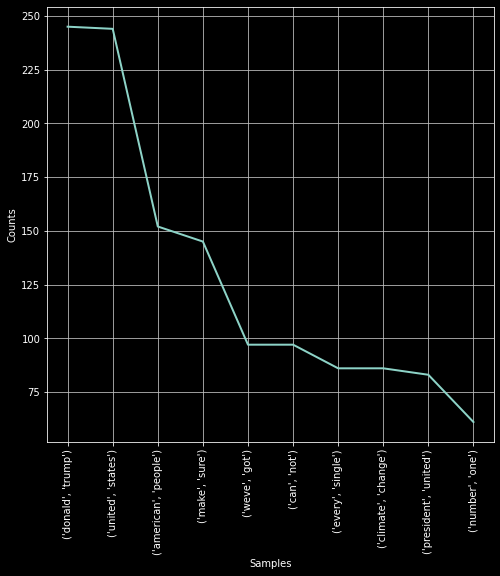

In [113]:
plt.figure(figsize=(8,8))
bigrams.plot(10)

This figure shows the 10 most frequent bigrams for all candidates

<h5> 2. Trigram</h5>

In [53]:
#Calculate the frequency of each couple
trigrams = FreqDist(ngrams(l, 3))
trigrams

FreqDist({('oh', 'didnt', 'miss'): 1,
          ('didnt', 'miss', 'anything'): 1,
          ('miss', 'anything', 'long'): 1,
          ('anything', 'long', 'race'): 1,
          ('long', 'race', 'took'): 1,
          ('race', 'took', 'hit'): 1,
          ('took', 'hit', 'iowa'): 1,
          ('hit', 'iowa', 'ill'): 1,
          ('iowa', 'ill', 'probably'): 1,
          ('ill', 'probably', 'take'): 1,
          ('probably', 'take', 'hit'): 1,
          ('take', 'hit', 'traditionally'): 1,
          ('hit', 'traditionally', 'bernie'): 1,
          ('traditionally', 'bernie', '20'): 1,
          ('bernie', '20', 'points'): 1,
          ('20', 'points', 'last'): 1,
          ('points', 'last', 'time'): 1,
          ('last', 'time', 'usually'): 1,
          ('time', 'usually', 'neighboring'): 1,
          ('usually', 'neighboring', 'senators'): 1,
          ('neighboring', 'senators', 'well'): 1,
          ('senators', 'well', 'matter'): 1,
          ('well', 'matter', 'im'): 1,
          (

In [54]:
#Select the 10 most frequent trigrams for all candidates
print(trigrams.most_common(10))

[(('president', 'united', 'states'), 83), (('united', 'states', 'america'), 44), (('beat', 'donald', 'trump'), 39), (('united', 'states', 'senate'), 29), (('student', 'loan', 'debt'), 25), (('number', 'one', 'number'), 23), (('defeat', 'donald', 'trump'), 22), (('fossil', 'fuel', 'industry'), 22), (('one', 'number', 'two'), 22), (('affordable', 'care', 'act'), 21)]


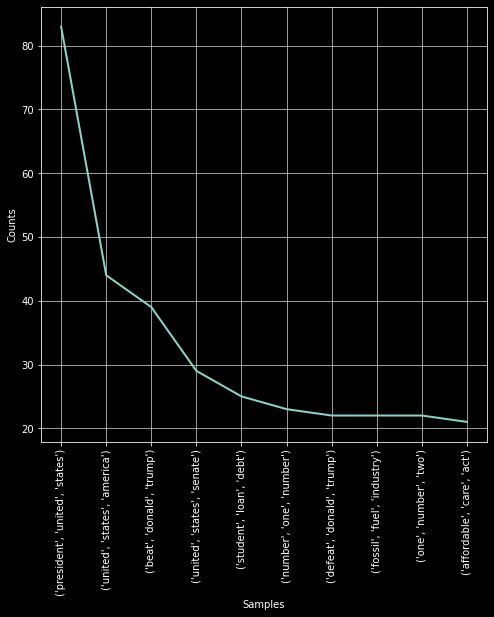

In [55]:
plt.figure(figsize=(8,8))
trigrams.plot(10)

<h4>Comparer le discours des candidats « Joe Biden » et « Bernie Sanders » </h4>

In [ ]:
# Collection of clear speech of Joe Biden in a single list named query_biden
eap = final[final['speaker'] == 'Joe Biden']
query_biden=[]
for i in eap["clean_tok"]:
    query_biden.append(i)

In [ ]:
#create a Dictionary that maps each word to a unique id.
#convert  sentences to a list of words and pass it to the corpora.Dictionary() .
dictionary = gensim.corpora.Dictionary(query_biden)
print(dictionary.token2id)

{'20': 0, 'always': 1, 'anything': 2, 'back': 3, 'bernie': 4, 'bring': 5, 'caucuses': 6, 'class': 7, 'country': 8, 'didnt': 9, 'doesnt': 10, 'encounters': 11, 'first': 12, 'four': 13, 'hit': 14, 'ill': 15, 'im': 16, 'iowa': 17, 'ive': 18, 'last': 19, 'long': 20, 'make': 21, 'matter': 22, 'middle': 23, 'miss': 24, 'neighboring': 25, 'next': 26, 'oh': 27, 'one': 28, 'people': 29, 'point': 30, 'points': 31, 'primaries': 32, 'probably': 33, 'proposition': 34, 'race': 35, 'reason': 36, 'restore': 37, 'senators': 38, 'simple': 39, 'soul': 40, 'starting': 41, 'still': 42, 'sure': 43, 'take': 44, 'time': 45, 'together': 46, 'took': 47, 'traditionally': 48, 'two': 49, 'usually': 50, 'view': 51, 'viewed': 52, 'well': 53, 'whether': 54, 'ability': 55, 'across': 56, 'african': 57, 'along': 58, 'americans': 59, 'bernies': 60, 'broad': 61, 'buttigieg': 62, 'candidate': 63, 'city': 64, 'democratic': 65, 'demonstrated': 66, 'done': 67, 'every': 68, 'everyone': 69, 'find': 70, 'get': 71, 'good': 72, 'g

In [ ]:
# Create a bag of words corpus and pass the tokenized list of words to the Dictionary.doc2bow()
corpus = [dictionary.doc2bow(gen_doc) for gen_doc in query_biden]
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 2),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 2),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 2),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 2),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1)],
 [(4, 1),
  (5, 1),
  (45, 1),
  (53, 2),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 2),
  (76, 1),
  (77, 1),
  (78, 2),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 2),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),

In [ ]:
# By using TF-IDF, words that appear more frequently in documents get smaller weights.
tf_idf = gensim.models.TfidfModel(corpus)
for doc in tf_idf[corpus]:
    print([[dictionary[id], np.around(freq, decimals=2)] for id, freq in doc])

[['20', 0.13], ['always', 0.14], ['anything', 0.1], ['back', 0.08], ['bernie', 0.11], ['bring', 0.18], ['caucuses', 0.18], ['class', 0.11], ['country', 0.08], ['didnt', 0.1], ['doesnt', 0.09], ['encounters', 0.18], ['first', 0.07], ['four', 0.1], ['hit', 0.32], ['ill', 0.12], ['im', 0.05], ['iowa', 0.15], ['ive', 0.07], ['last', 0.12], ['long', 0.1], ['make', 0.06], ['matter', 0.16], ['middle', 0.1], ['miss', 0.18], ['neighboring', 0.18], ['next', 0.12], ['oh', 0.15], ['one', 0.05], ['people', 0.04], ['point', 0.09], ['points', 0.15], ['primaries', 0.18], ['probably', 0.16], ['proposition', 0.18], ['race', 0.16], ['reason', 0.1], ['restore', 0.12], ['senators', 0.13], ['simple', 0.18], ['soul', 0.12], ['starting', 0.16], ['still', 0.12], ['sure', 0.06], ['take', 0.09], ['time', 0.06], ['together', 0.08], ['took', 0.12], ['traditionally', 0.18], ['two', 0.14], ['usually', 0.18], ['view', 0.14], ['viewed', 0.18], ['well', 0.07], ['whether', 0.1]]
[['bernie', 0.11], ['bring', 0.09], ['tim

In [ ]:
# Creation of a similarity object
# Storing the index array in the 'workdir' directory
sims = gensim.similarities.Similarity('C:/Users/HP/Downloads/work',tf_idf[corpus],
                                        num_features=len(dictionary))

We do the same work for the candidate Bernie Sanders

In [ ]:
eap = final[final['speaker'] == 'Bernie Sanders']
query_bernie=[]
for i in eap["clean_tok"]:
    query_bernie.append(i)

In [ ]:
dictionaryB = gensim.corpora.Dictionary(query_bernie)
print(dictionaryB.token2id)

{'000232': 0, 'affairs': 1, 'amy': 2, 'anybody': 3, 'damn': 4, 'day': 5, 'defeat': 6, 'disgusting': 7, 'doesnt': 8, 'donald': 9, 'elizabeth': 10, 'else': 11, 'end': 12, 'everybody': 13, 'george': 14, 'inaudible': 15, 'joe': 16, 'lies': 17, 'matter': 18, 'really': 19, 'sad': 20, 'say': 21, 'says': 22, 'stand': 23, 'state': 24, 'terrible': 25, 'thing': 26, 'things': 27, 'think': 28, 'time': 29, 'together': 30, 'trump': 31, 'ugly': 32, 'united': 33, 'way': 34, 'wins': 35, '29': 36, '30': 37, '6000': 38, 'appealing': 39, 'beat': 40, 'believe': 41, 'bring': 42, 'class': 43, 'country': 44, 'dont': 45, 'feeling': 46, 'given': 47, 'got': 48, 'hearing': 49, 'history': 50, 'increased': 51, 'iowa': 52, 'largest': 53, 'nationally': 54, 'pain': 55, 'people': 56, 'perceiving': 57, 'political': 58, 'popular': 59, 'process': 60, 'proud': 61, 'significant': 62, 'turnout': 63, 'vote': 64, 'voter': 65, 'votes': 66, 'working': 67, 'young': 68, '2008': 69, 'aspect': 70, 'better': 71, 'bringing': 72, 'came'

In [ ]:
corpusB = [dictionaryB.doc2bow(gen_doc) for gen_doc in query_bernie]
corpusB

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 2),
  (7, 1),
  (8, 1),
  (9, 4),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 2),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 2),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 4),
  (32, 1),
  (33, 1),
  (34, 2),
  (35, 1)],
 [(3, 1),
  (6, 1),
  (9, 1),
  (31, 2),
  (34, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 2),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 3),
  (56, 3),
  (57, 1),
  (58, 2),
  (59, 1),
  (60, 2),
  (61, 1),
  (62, 2),
  (63, 2),
  (64, 1),
  (65, 2),
  (66, 1),
  (67, 1),
  (68, 2)],
 [(6, 1),
  (28, 1),
  (31, 1),
  (54, 1),
  (56, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 2),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 2),
  (79, 1),
  (80, 1),


In [ ]:
# Calculation of similarity
query_doc_tf_idf = tf_idf[corpusB]
print('Comparing Result:', sims[query_doc_tf_idf]) 

Comparing Result: [[0.68766636 0.0171929  0.06548075 ... 0.         0.         0.        ]
 [0.39192817 0.36772406 0.0077638  ... 0.         0.         0.        ]
 [0.09459493 0.61691743 0.03914006 ... 0.         0.         0.        ]
 ...
 [0.09025721 0.         0.         ... 0.         0.         0.        ]
 [0.01544193 0.0494455  0.10397518 ... 0.         0.         0.        ]
 [0.01321317 0.0429852  0.02242868 ... 0.         0.         0.        ]]


In [ ]:
# Calculate the sum of similarity coefficients
sum_of_sims =(np.sum(sims[query_doc_tf_idf], dtype=np.float32))
print(sum_of_sims)

1270.073


In [ ]:
# Calculate the total number of similarity coefficients
sum = 0
for i in query_biden:
    sum = sum + len(i)

In [ ]:
percentage_of_similarity = round(float((sum_of_sims / sum)) * 100)
print(f'Average similarity float: {float(sum_of_sims / sum)}')
print(f'Average similarity percentage: {float(sum_of_sims / sum) * 100}')
print(f'Average similarity rounded percentage: {percentage_of_similarity}')

Average similarity float: 0.10412141318633178
Average similarity percentage: 10.412141318633179
Average similarity rounded percentage: 10


**Analyse des sentiments : On s’intéresse maintenant à une analyse des divers discours en les classant comme positifs ou négatifs.**


Now , we’ll use an IMDB dataset of 50k movie reviews from Kaggle.
The dataset contains 2 columns review and sentiment that will help us identify whether a review is positive or negative.
Our goal is to find  out which machine learning or deep learning model is best suited to predict sentiment  given a movie review. 


In [56]:
#Import of the IMBD database
data=pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')

This dataset contains 50000 rows

<h4> We perform in the upcoming steps: cleaning on the dataset and exploratory data analysis</h4>



In [57]:
#Identify duplicates
num_duplicates = data.duplicated().sum() 
print('There are {} duplicate reviews present in the dataset'.format(num_duplicates))

There are 418 duplicate reviews present in the dataset


In [58]:
#Dropping duplicates
data.drop_duplicates(inplace = True)

In [59]:
#Removing stopwords
stop = stopwords.words('english')
wl = WordNetLemmatizer()

In [60]:
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
           "'cause": "because", "could've": "could have", "couldn't": "could not", 
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
           "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
           "she's": "she is", "should've": "should have", "shouldn't": "should not", 
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
                      "that'd": "that would", "that'd've": "that would have", "that's": "that is", 
           "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
           "here's": "here is","they'd": "they would", "they'd've": "they would have", 
           "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
           "we're": "we are", "we've": "we have", "weren't": "were not", 
           "what'll": "what will", "what'll've": "what will have","what're": "what are",  
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", 
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
             "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
           "you're": "you are", "you've": "you have" }

<li>Process of clearing punctuation marks in data</li>
<li>Cleaning unnecessary marks in data. </li>
<li>Capitalization to lowercase.</li>
<li>Cleaning extra spaces.</li>
<li>Removal of stopwords in sentences. </li>

In [61]:
def clean_text(text,lemmatize = True):
    #remove html tags
    soup = BeautifulSoup(text, "html.parser") 
    text = soup.get_text()
    
    #expanding chatwords and contracts clearing contractions
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji_clean.sub(r'',text)
    #add space after full stop
    text = re.sub(r'\.(?=\S)', '. ',text) 
    text = re.sub(r'http\S+', '', text) 
    #remove urls
    text = "".join([word.lower() for word in text if word not in string.punctuation]) 
    #remove punctuation
    #tokens = re.split('\W+', text) #create tokens
    if lemmatize:
        text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) #lemmatize
    else:
        text = " ".join([word for word in text.split() if word not in stop and word.isalpha()]) 
    return text

In [62]:
#Cleaning the database 'Data' with the clean_text function
data['review']=data['review'].apply(clean_text,lemmatize = True)

In [63]:
#Converting target variable to numeric labels
data.sentiment = [ 1 if each == "positive" else 0 for each in data.sentiment]

In [64]:
#Splitting into train and test
train, test= train_test_split(data, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']

In [65]:
Xtrain

7837     really liked movie emporers new groove watchin...
4814     decided watch movie noted scariest movie ever ...
35458    hard say going lady shanghai film could withou...
3446     scifi adventure best mean worst agree statemen...
24478    around late animator bluth frustrated output c...
                               ...                        
11304    dictated thin experience life industry cash so...
45059    classic case something never gloria single mot...
38405    spoiler spoilersi saw movie last night screeni...
860      production quite surprise absolutely love obsc...
15838    real eye candy world made floating island flyi...
Name: review, Length: 39665, dtype: object

<h3>4. Modeling  and Evaluation</h3>

**SVM Model**

Using the imdb dataset, we will train our SVM model with positive and negative comments about movies. First, we will make comments available for the SVM model. After training our model, we will examine the accuracy on the chart.

In [66]:
#Vectorizing data

#tfidfVectorizer
tfidf_vect = TfidfVectorizer() 
Xtrain_tfidf = tfidf_vect.fit_transform(Xtrain)
Xtest_tfidf = tfidf_vect.transform(Xtest)

#CountVectorizer
count_vect = CountVectorizer() 
Xtrain_count = count_vect.fit_transform(Xtrain)
Xtest_count = count_vect.transform(Xtest)

TF-IDF Vectorization
The last major step of our preprocessing was to use term frequency-inverse document frequency (TF-IDF) vectorization to separate the words. Because a computer program can’t properly understand words, the text needs to be converted to numbers.

One simple way is to simply count how many times each word appears within the line (“count vectorization”), so you end up with a count value for each word. We did originally try that, but it led to topic modeling reducing to many similar topics that didn’t quite differentiate from each other, and didn’t really allow us to analyze debates.

We then tried utilizing TF-IDF vectorization, which worked much better in this application. With some more specialized words and topics here that related to politics and policy, this approach gave us the best results, different topics that were more easily interpretable.

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.



In [67]:
#Call LinearSVC from sklearn.svm
linear_svc = LinearSVC(penalty='l2',loss = 'hinge')
linear_svc.fit(Xtrain_tfidf,ytrain)

LinearSVC(loss='hinge')

In [68]:
p3=linear_svc.predict(Xtest_tfidf)
s3=accuracy_score(ytest,p3)
print("Linear Support Vector Classifier Accuracy :", "{:.2f}%".format(100*s3))

Linear Support Vector Classifier Accuracy : 89.57%


A confusion matrix is a table that allows visualization of the performance of an algorithm. This table typically has two rows and two columns that report the number of false positives, false negatives, true positives, and true negatives

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


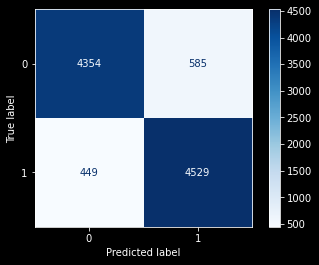

In [69]:
plot_confusion_matrix(linear_svc, Xtest_tfidf, ytest,cmap = 'Blues')
plt.grid(False)

OBSERVATION 1: The Classifier test set accuracy is 85 %

**Naive bayes Model**

Naive Bayes is the simplest and fastest classification algorithm for a large chunk of data. In various applications such as spam filtering, text classification, sentiment analysis, and recommendation systems, Naive Bayes classifier is used successfully. It uses the Bayes probability theorem for unknown class prediction.

After splitting and vectorize text reviews into numbers, we will generate a random forest model on the training set and perform prediction on test set features.

In [70]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB().fit(Xtrain_tfidf,ytrain)

In [71]:
p2=clf.predict(Xtest_tfidf)
s2=accuracy_score(ytest,p2)
print("Bernoulli Naive Bayes Classifier Accuracy :", "{:.2f}%".format(100*s2))

Bernoulli Naive Bayes Classifier Accuracy : 85.64%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


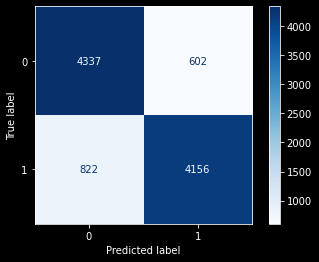

In [72]:
plot_confusion_matrix(clf, Xtest_tfidf, ytest,cmap = 'Blues')
plt.grid(False)

OBSERVATION 2: Check the correctness of the model after it has been created by comparing real and anticipated values. This model is 85 % accurate.





**LSTM Model**
: Long Short Term Memory

LSTM is an updated version of Recurrent Neural Network to overcome the vanishing gradient problem. Below is the architecture of LSTM with an explanation.

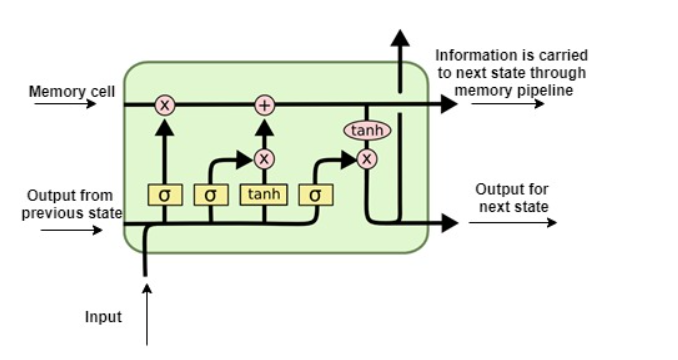

<li>Recall that we have imported the keras libraries before</li>
<li>Use Tokenizer from keras</li>

In [73]:
tokenizer = Tokenizer(num_words = 10000,oov_token="<oov>")
tokenizer.fit_on_texts(Xtrain)
word_index = tokenizer.word_index

In [74]:
V = len(word_index)
print("Vocabulary of the dataset is : ",V)

Vocabulary of the dataset is :  126096


In [75]:
#Create sequences of reviews
seq_train = tokenizer.texts_to_sequences(Xtrain)
seq_test =  tokenizer.texts_to_sequences(Xtest)

In [76]:
#Choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

In [77]:
#If we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

Maximum length of sequence in the list: 1406


In [78]:
#When setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

Maximum length of the sequence when considering data only two standard deviations from average: 293


In [79]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

The above calculated number coveres approximately 94.51 % of data


In [80]:
#create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [81]:
#Splitting training set for validation purposes
Xtrain,Xval,ytrain,yval=train_test_split(pad_train,ytrain,
                                             test_size=0.2,random_state=10)

V – This hyperparameter refers to the number of words to keep based on the frequency of words.
Split – This hyperparameter refers to the separator used for splitting the word.
pad_sequence() function is used to convert a list of sequences into a 2D NumPy array.

Here We Create LSTM model and we Train it  for 5 epochs:This step involves model initialization, adding required LSTM layers, and model compilation

\






In [82]:
def lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

   
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    r = model.fit(Xtrain,ytrain, 
                  validation_data = (Xval,yval), 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32)
                  
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [83]:
r,model,n_epochs = lstm_model(Xtrain,Xval,ytrain,yval,V,64,max_seq_len,5)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 293)]             0         
                                                                 
 embedding (Embedding)       (None, 293, 64)           8070208   
                                                                 
 batch_normalization (BatchN  (None, 293, 64)          256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 293, 64)           0         
                                                                 
 conv1d (Conv1D)             (None, 289, 32)           10272     
                                                                 
 dropout_1 (Dropout)         (None, 289, 32)           0         
                                                             

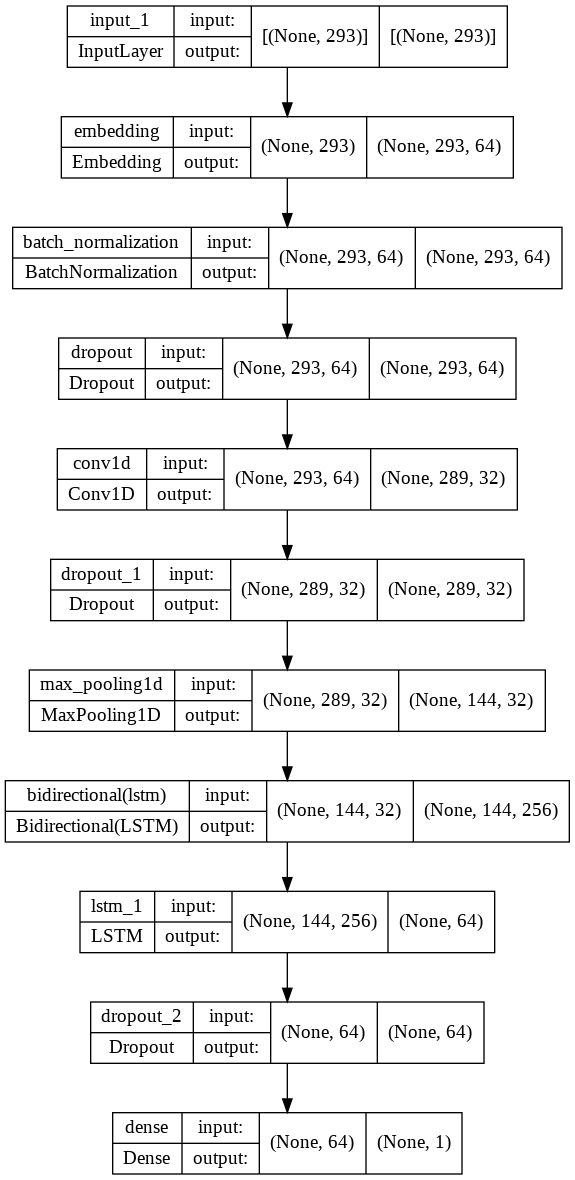

In [84]:
keras.utils.plot_model(model,'my_first_model_with_shape_info.png',show_shapes=True)

In [85]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(pad_test,ytest)
print(dict(zip(model.metrics_names, result)))

Evaluate Model Performance on Test set
310/310 [==============================] - 4s 13ms/step - loss: 0.3712 - accuracy: 0.8710
{'loss': 0.37115973234176636, 'accuracy': 0.8710295557975769}


OBSERVATION 3:
The model test set accuracy is 88 %; after 5 epochs

The best model between the 3 classifiers is SVM with an accuracy of 89.57

<h4>Utiliser la réponse la plus dominante des 3 classifeurs2 afin de préciser le candidat qui a le
discours le plus positif (sur l’ensemble de ses interventions) et celui qui a le discours le plus
négatif (sur l’ensemble de ses interventions).</h4>

<h3>5. Deployment </h3>

**Applications of the 3 classifiers on the Debat_Transcripts_USA database**

In [86]:
final['clean_speech']=final['speech'].apply(clean_text,lemmatize = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [87]:
tfid_cleanspeech = tfidf_vect.transform(final['clean_speech'])

SVM

In [88]:
#Apply the svm model on the database Debat_Trascripts_USA
pred_SVM=linear_svc.predict(tfid_cleanspeech)
pred_SVM

array([1, 1, 0, ..., 0, 0, 1])

Naive Bayes

In [89]:
#Apply the naive bayes model on the database Debat_Trascripts_USA
pred_NAIVE=clf.predict(tfid_cleanspeech)
pred_NAIVE

array([1, 1, 0, ..., 1, 0, 0])

LSTM

In [90]:
tokenizer = Tokenizer(num_words = 10000,oov_token="<oov>")
tokenizer.fit_on_texts(final["clean_speech"])
word_index = tokenizer.word_index

In [91]:
V1 = len(word_index)
print("Vocabulary of the dataset is : ",V1)

Vocabulary of the dataset is :  6538


In [92]:
#Create sequences of clean_speech
seq_f = tokenizer.texts_to_sequences(final["clean_speech"])

In [93]:
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

Maximum length of sequence in the list: 1406


In [94]:
max_seq = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq = int(max_seq)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

Maximum length of the sequence when considering data only two standard deviations from average: 293


In [95]:
perc = np.sum(np.array(seq_len_list) < max_seq) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

The above calculated number coveres approximately 94.51 % of data


In [96]:
#Create padded sequences
pad_f = pad_sequences(seq_f,truncating = 'post', padding = 'pre',maxlen=max_seq)

In [97]:
#Apply the lstm model on the database Debat_Trascripts_USA
pred_LSTM = model(pad_f)

In [98]:
pred_LSTM = (np.round(pred_LSTM)).astype('int')
pred_LSTM

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [99]:
#Adding a new column pred_SVM which contains the result of the svm model in the final database 
final.insert(6,'pred_SVM',0)
final['pred_SVM'] = pred_SVM

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [100]:
#Adding a new column pred_NAIIVE which contains the result of the naive bayes model in the final database 
final.insert(7,'pred_NAIVE',0)
final['pred_NAIVE'] = pred_NAIVE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [101]:
#Adding a new column pred_LSTM which contains the result of the lstm model in the final database 
final.insert(8,'pred_LSTM',0)
final['pred_LSTM'] = pred_LSTM

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [102]:
#This function uses the principle of the most dominant response of the 3 classifiers. 
#For example, if we have 1,1,0 then the function result adds 1 to the list res
def result (x,y,z):
  res = []
  sum= x + y + z
  if sum >=2:
    res.append(1)
  else:
    res.append(0) 
  return res

In [103]:
V =final.apply(lambda row: result (row['pred_SVM'],row['pred_NAIVE'],row['pred_LSTM']), axis=1)

In [104]:
##Adding a new column Pos/Neg which contains V
final.insert(9,'Pos/Neg',0) 
final['Pos/Neg'] = V

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [105]:
#Replace the 1 by Pos and the 0 by Neg
final["Pos/Neg"] = ["Pos"  if each == [1] else" Neg" for each in final["Pos/Neg"] ]
final

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,debate_name,debate_section,speaker,speech,speaking_time_seconds,clean_speech,pred_SVM,pred_NAIVE,pred_LSTM,Pos/Neg,clean_tok
1,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Oh, they didn’t miss anything. It’s a long rac...",36.0,oh miss anything long race took hit iowa proba...,1,1,1,Pos,"[oh, didnt, miss, anything, long, race, took, ..."
3,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Well, you know that with regard to Senator San...",41.0,well know regard senator sander president want...,1,1,0,Pos,"[well, know, regard, senator, sanders, preside..."
5,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,Because Donald Trump lies all the time. It doe...,41.0,donald trump lie time matter donald trump say ...,0,0,0,Neg,"[donald, trump, lies, time, doesnt, matter, do..."
6,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,I believe that the way we beat Trump is by hav...,39.0,believe way beat trump largest voter turnout h...,0,1,0,Neg,"[believe, way, beat, trump, largest, voter, tu..."
8,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,That’s true. And that’s the disappointment and...,23.0,true disappointment think u probably could don...,0,0,0,Neg,"[true, disappointment, think, probably, could,..."
...,...,...,...,...,...,...,...,...,...,...,...
5324,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Joe Biden,… there would be 10 … Six million members woul...,2.0,would six million member would,0,0,0,Neg,"[10, six, million, members]"
5326,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Joe Biden,… now American citizens.,2.0,american citizen,1,0,0,Neg,"[american, citizens]"
5328,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Bernie Sanders,"Unfortunately Rulac, among other groups, Latin...",17.0,unfortunately rulac among group latino group s...,0,1,0,Neg,"[unfortunately, rulac, among, groups, latino, ..."
5329,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Bernie Sanders,"But where we don’t agree, I think, is why we a...",24.0,agree think today major country earth guarante...,0,0,0,Neg,"[dont, agree, think, today, major, country, ea..."


In [112]:
#This function calculates the total number of Pos and Neg for each condidate
def PosNeg_condidat (x):
    eap = final[final['speaker'] == x]
    nbrNeg = 0
    nbrPos = 0 
    for i in eap["Pos/Neg"]:
      if i == 'Pos':
        nbrPos += 1
      else:
        nbrNeg += 1
    return (nbrPos,nbrNeg)

In [107]:
l = []
for i in df2.index:
  l.append((i,PosNeg_condidat(i)))
l

[('Amy Klobuchar', (108, 178)),
 ('Andrew Yang', (45, 61)),
 ('Bernie Sanders', (118, 243)),
 ('Beto O’Rourke', (44, 37)),
 ('Cory Booker', (60, 60)),
 ('Elizabeth Warren', (106, 250)),
 ('Joe Biden', (118, 280)),
 ('Julian Castro', (21, 39)),
 ('Kamala Harris', (70, 126)),
 ('Pete Buttigieg', (132, 206)),
 ('Tom Steyer', (50, 60)),
 ('Tulsi Gabbard', (36, 19))]

In [108]:
max=  l[0][1][0]
for i in range(len(l)):
  if l[i][1][0]> max:
    name = l[i][0]
    max =l[i][1][0]
print ('Le candidat qui a le discours le plus positif sur l’ensemble de ses interventions est',name,":",max,"interventions positives")

Le candidat qui a le discours le plus positif sur l’ensemble de ses interventions est Pete Buttigieg : 132 interventions positives


In [109]:
max_neg=  l[0][1][1]
for i in range(len(l)): 
  if l[i][1][1]> max_neg:
    name = l[i][0]
    max_neg =l[i][1][1]
print ('Le candidat qui a le discours le plus negatif sur l’ensemble de ses interventions est',name,":",max_neg,"interventions negatives")

Le candidat qui a le discours le plus negatif sur l’ensemble de ses interventions est Joe Biden : 280 interventions negatives
